In [29]:
%%time
import os
import re
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

import lightgbm as lgb
from tqdm.auto import tqdm, trange
from lightgbm import log_evaluation, early_stopping

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score, accuracy_score

CPU times: user 27 µs, sys: 20 µs, total: 47 µs
Wall time: 54.1 µs


In [30]:
os.getcwd()

'/Users/jamesbyers/Documents/Code/ai/my_work/Kaggle'

In [31]:
path = os.path.join('Learning Agency Lab - Automated Essay Scoring 2.0/data','train.csv')

columns = [(pl.col('full_text').str.split(by='\n\n').alias('paragraph'))]

train = pl.read_csv(path).with_columns(columns)
train = train.with_columns([pl.col('paragraph').map_elements(lambda x: len(x)).alias('paragraph_count')])

/var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_49281/2131321762.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train = train.with_columns([pl.col('paragraph').map_elements(lambda x: len(x)).alias('paragraph_count')])


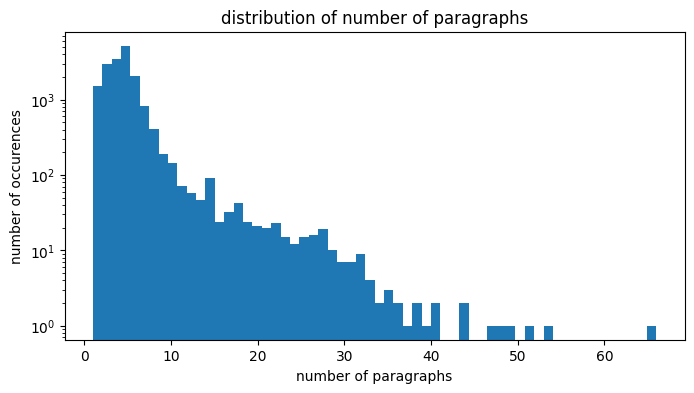

In [33]:
def plot_para_count_distribution():
    _ = plt.figure(figsize=(8,4))
    plt.hist(train['paragraph_count'], bins=60, log=True)
    plt.xlabel('number of paragraphs')
    plt.ylabel('number of occurences')
    plt.title('distribution of number of paragraphs')
    plt.show()

plot_para_count_distribution()

In [39]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    
    return x

In [40]:
%%time

def Paragraph_Preprocess(df):
    # Expand the paragraph list into several lines of data
    df = df.explode('paragraph')

    # Paragraph preprocessing
    df = df.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))

    # Calculate the length of each paragraph
    df = df.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))

    # Calculate the number of sentences and words in each paragraph
    df = df.with_columns(
        pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
        pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"))

    return df

paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']

def Paragraph_Eng(df):
    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
        ]
    df = df.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    
    return df

tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']

# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))

print('Features Number: ',len(feature_names))
train_feats.head(3)

<timed exec>:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
<timed exec>:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Features Number:  31
CPU times: user 2.05 s, sys: 51.7 ms, total: 2.1 s
Wall time: 2.08 s


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,score
0,000d118,1,1,1,1,1,1,1,1,1,...,2640,14,491,2640,14,491,2640,14,491,3
1,000fe60,5,5,5,5,5,5,4,3,3,...,184,3,37,184,4,37,235,3,46,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,476,5,85,576,5,101,476,5,85,4


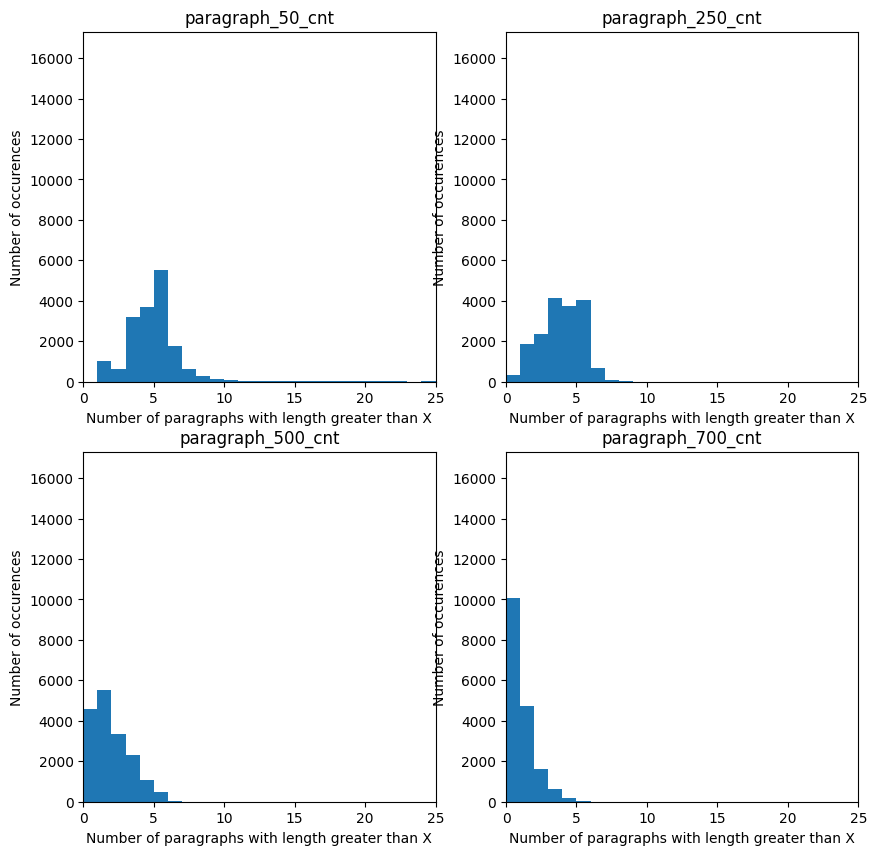

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
feats = ['paragraph_50_cnt', 'paragraph_250_cnt', 'paragraph_500_cnt', 'paragraph_700_cnt']
num = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(train_feats[feats[num]], bins=[i for i in range(40)])
        axes[i, j].set_xlim((0, 25))
        axes[i, j].set_ylim((0, len(train_feats)))
        axes[i, j].set_title(feats[num])
        axes[i, j].set_xlabel('Number of paragraphs with length greater than X')
        axes[i, j].set_ylabel('Number of occurences')
        num += 1
plt.show()

In [43]:
%%time

def Sentence_Preprocess(tmp):
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')

    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))

    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)

    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp

sentence_fea = ['sentence_len','sentence_word_cnt']

def Sentence_Eng(train_tmp):
    aggs = [
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    
    return df

tmp = Sentence_Preprocess(train)

# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
<timed exec>:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
<timed exec>:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Features Number:  48
CPU times: user 1.97 s, sys: 57.6 ms, total: 2.03 s
Wall time: 2 s


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


In [44]:
%%time

def Word_Preprocess(tmp):
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')

    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))

    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp

def Word_Eng(train_tmp):
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    
    return df

tmp = Word_Preprocess(train)

# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
<timed exec>:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Features Number:  69
CPU times: user 3.26 s, sys: 511 ms, total: 3.77 s
Wall time: 3.4 s


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [45]:
%%time

vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(1,3),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

# Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])

# Convert to array
dense_matrix = train_tfid.toarray()

# Convert to dataframe
df = pd.DataFrame(dense_matrix)

# rename features
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']

# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  3360
CPU times: user 18.9 s, sys: 430 ms, total: 19.4 s
Wall time: 19.7 s


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,tfid_3281,tfid_3282,tfid_3283,tfid_3284,tfid_3285,tfid_3286,tfid_3287,tfid_3288,tfid_3289,tfid_3290
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.034738,0.071064,0.0,0.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [46]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective

def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True

a = 2.948
b = 1.092

In [47]:
%%time

LOAD = False
models = []
if LOAD:
    for i in range(5):
        models.append(lgb.Booster(model_file=f'../input/lal-lgb-baseline-4/fold_{i}.txt'))
else:
    # oof用于存储每一次模型对验证集的预测结果
    # OOF is used to store the prediction results of each model on the validation set
    oof = []
    x= train_feats
    y= train_feats['score'].values
    # 5 fold
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
    for fold_id, (trn_idx, val_idx) in tqdm(enumerate(kfold.split(x.copy(), y.copy().astype(str)))):
            # 创建模型
            # create model
            model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.1,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.5,
                reg_alpha = 0.1,
                reg_lambda = 0.8,
                n_estimators=1024,
                random_state=42,
                verbosity = - 1)
            # 分别取出5 kfold分割的训练集和验证集
            # Take out the training and validation sets for 5 kfold segmentation separately
            X_train = train_feats.iloc[trn_idx][feature_names]
            Y_train = train_feats.iloc[trn_idx]['score'] - a

            X_val = train_feats.iloc[val_idx][feature_names]
            Y_val = train_feats.iloc[val_idx]['score'] - a
            print('\nFold_{} Training ================================\n'.format(fold_id+1))
            # 训练模型
            # Training model
            lgb_model = model.fit(X_train,
                                  Y_train,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train, Y_train), (X_val, Y_val)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
            # 使用训练完成的模型对验证集进行预测
            # Use the trained model to predict the validation set
            pred_val = lgb_model.predict(
                X_val, num_iteration=lgb_model.best_iteration_)
            df_tmp = train_feats.iloc[val_idx][['essay_id', 'score']].copy()
            df_tmp['pred'] = pred_val + a
            oof.append(df_tmp)
            # 保存模型参数
            # Save model parameters
            models.append(model.booster_)
            lgb_model.booster_.save_model(f'fold_{fold_id}.txt')
    df_oof = pd.concat(oof)
    

0it [00:00, ?it/s]


Fold_1 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.750601	valid's QWK: 0.742375
[50]	train's QWK: 0.795632	valid's QWK: 0.779325
[75]	train's QWK: 0.81359	valid's QWK: 0.792583
[100]	train's QWK: 0.826584	valid's QWK: 0.799451
[125]	train's QWK: 0.834344	valid's QWK: 0.801623
[150]	train's QWK: 0.843072	valid's QWK: 0.8
[175]	train's QWK: 0.85002	valid's QWK: 0.7999
Early stopping, best iteration is:
[120]	train's QWK: 0.832841	valid's QWK: 0.803195
Evaluated only: QWK

Fold_2 Training ================================

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.753578	valid's QWK: 0.736747
[50]	train's QWK: 0.797361	valid's QWK: 0.773929
[75]	train's QWK: 0.814807	valid's QWK: 0.787045
[100]	train's QWK: 0.826414	valid's QWK: 0.791377
[125]	train's QWK: 0.834

(array([2.785e+03, 2.730e+02, 1.330e+02, 5.900e+01, 3.800e+01, 2.800e+01,
        1.500e+01, 7.000e+00, 4.000e+00, 7.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ,
        12.1, 13.2, 14.3, 15.4, 16.5, 17.6, 18.7, 19.8, 20.9, 22. , 23.1,
        24.2, 25.3, 26.4, 27.5, 28.6, 29.7, 30.8, 31.9, 33. ]),
 <BarContainer object of 30 artists>)

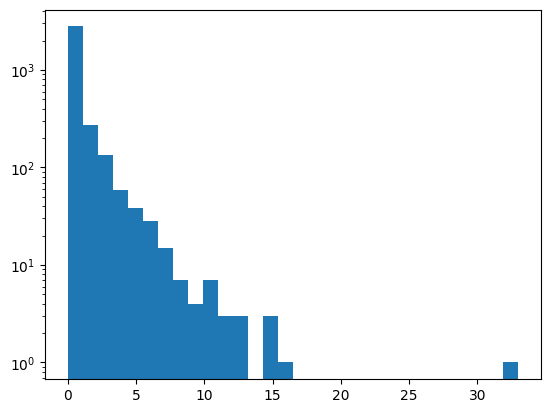

In [70]:
plt.hist(importances, log=True, bins=30)

In [67]:
feature_names

Index(['essay_id', 'paragraph_50_cnt', 'paragraph_75_cnt', 'paragraph_100_cnt',
       'paragraph_125_cnt', 'paragraph_150_cnt', 'paragraph_175_cnt',
       'paragraph_200_cnt', 'paragraph_250_cnt', 'paragraph_300_cnt',
       ...
       'tfid_3281', 'tfid_3282', 'tfid_3283', 'tfid_3284', 'tfid_3285',
       'tfid_3286', 'tfid_3287', 'tfid_3288', 'tfid_3289', 'tfid_3290'],
      dtype='object', length=3362)

In [63]:
importances = model.feature_importances_
feature_names = train_feats.columns
feature_names.drop(['Score'])

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

KeyError: "['Score'] not found in axis"

In [57]:
top_features = feature_importance_df.sort_values(['importance'],reverse=True).head(20)

NameError: name 'feature_importance_df' is not defined

In [54]:
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()

NameError: name 'top_features' is not defined

<Figure size 1000x800 with 0 Axes>